# Régression : Prédire la pression artérielle systolique (ap_hi) à partir des autres variables (âge, sexe, poids, cholestérol, glucose, comportement, etc...)

# Introduction
Dans ce projet, nous allons prédire la pression artérielle systolique (`ap_hi`) à partir des autres variables (âge, sexe, poids, cholestérol, glucose, comportement, etc...). Pour la modélisation de la variable continue (ici, la pression artérielle systolique `ap_hi`), nous avons retenu :
- Random Forest Regressor (méthode ensembliste - bagging) : robuste, efficace, gère bien les grands jeux de données et les relations non linéaires.
- Gradient Boosting Regressor (méthode ensembliste - boosting) : performant sur les données tabulaires, capture les interactions complexes.
- Linear Regression (méthode classique vue en cours) : baseline rapide et interprétable, permet de comparer les progrès des méthodes ensemblistes.
- SGD Regressor (méthode non vue en cours, scalable) : très rapide, adapté aux très grands volumes de données, supporte la régularisation pour éviter le surapprentissage.

La variable à prédire choisie est la pression artérielle systolique (`ap_hi`), un facteur de risque cardiovasculaire majeur.
Chaque modèle sera évalué avec les métriques classiques de régression : R², MSE, RMSE, MAE, et visualisé par des courbes de dispersion prédiction/réel.

NB : Nous avons essayé de laisser tourner les codes des modèles de régression pour espérer améliorer nos performances, mais mon ordinateur a planté. De ce fait, on a préféré laisser nos performances comme elles étaient.

## 1. Chargement et Exploration des Données

### a. Importation des bibliothèques

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

### b. Chargement du dataset
Nous avons utilisé pour ce projet le dataset ou base de données « cardio_train.csv », une base de données médicale comprenant 70 000 patients et 12 variables explicatives :
- Variables démographiques : âge (`age` en jours), genre, taille et poids,
- Variables cliniques : pression artérielle systoliques (`ap_hi`) et diastolique (`ap_lo`), taux de cholestérol (`cholesterol`) et glucose sanguin (`gluc`),
- Variables comportementales : tabagisme (`smoke`), consommation d’alcool (`alco`) et activité physique (`active`),
- Variable cible ou target : présence (1) ou absence (0) de maladie cardiovasculaire (`cardio`)

In [2]:
df = pd.read_csv('cardio_train.csv', sep=';')

### c. Aperçu des données
On veut ici comprendre la structure, la qualité et la distribution des données. Pour ce faire, on affiche toutes les informations sur le dataset, les premières lignes, les statistiques descriptives des varaibles numériques, la distribution de la variable cible `cardio` et la visualisation de la distribution de cette varaible cible.


Premières lignes du dataset :
   id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  

Informations sur le dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 

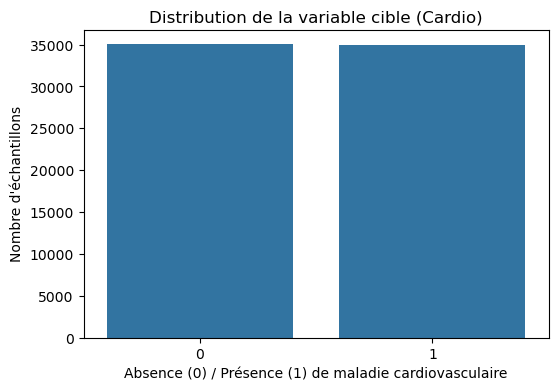

In [3]:
if df is not None:
    print("\nPremières lignes du dataset :")
    print(df.head())

    print("\nInformations sur le dataset :")
    print(df.info())

    print("\nStatistiques descriptives des variables numériques :")
    print(df.describe())

    print("\nDistribution de la variable cible 'cardio' :")
    print(df['cardio'].value_counts())

    plt.figure(figsize=(6, 4))
    sns.countplot(x='cardio', data=df)
    plt.title('Distribution de la variable cible (Cardio)')
    plt.xlabel('Absence (0) / Présence (1) de maladie cardiovasculaire')
    plt.ylabel('Nombre d\'échantillons')
    plt.show()

Pour la distribution des classes (0/1), on remarque qu'elle est quasi parfaitement équilibrée (50.03% vs 49.97%), évitant ainsi le problème classique de déséquilibre des classes.

## 2. Prétraitement initial

Nous allons vérifier s'il y'a des valeurs maleurs manquantes et les imputer, et aussi séparer les features et de la target.

In [4]:
if df is not None:
    # Vérification des valeurs manquantes
    print("\nNombre de valeurs manquantes par colonne :")
    print(df.isnull().sum())

    # Imputation des valeurs manquantes : Imputation par la moyenne pour les colonnes numériques
    for col in df.select_dtypes(include=np.number).columns:
        if df[col].isnull().any():
            mean_val = df[col].mean()
            df[col].fillna(mean_val, inplace=True)
            print(f"Valeurs manquantes dans '{col}' imputées avec la moyenne ({mean_val:.2f}).")

    # Imputation des valeurs manquantes : Imputation par le mode pour les colonnes catégorielles 
    for col in df.select_dtypes(include='object').columns: # Par contre dans mon dataset les catégorielles sont déjà numériques
        if df[col].isnull().any():
            mode_val = df[col].mode()[0]
            df[col].fillna(mode_val, inplace=True)
            print(f"Valeurs manquantes dans '{col}' imputées avec le mode ({mode_val}).")

    print("\nNombre de valeurs manquantes après imputation :")
    print(df.isnull().sum())
    
    # On sépare les features (X) et la target (y)
    X = df.drop('cardio', axis=1)
    y = df['cardio']

    print("\nFeatures (X) shape :", X.shape)
    print("Target (y) shape :", y.shape)


Nombre de valeurs manquantes par colonne :
id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

Nombre de valeurs manquantes après imputation :
id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

Features (X) shape : (70000, 12)
Target (y) shape : (70000,)


On remarque que notre dataset ne contient pas de valeurs manquantes.

### a. Analyse des données 
Ici on va analyser les données pour observer les outliers et on affiche la matrice entre la cible et les variables de corrélation pour nous aider à la sélection des features.

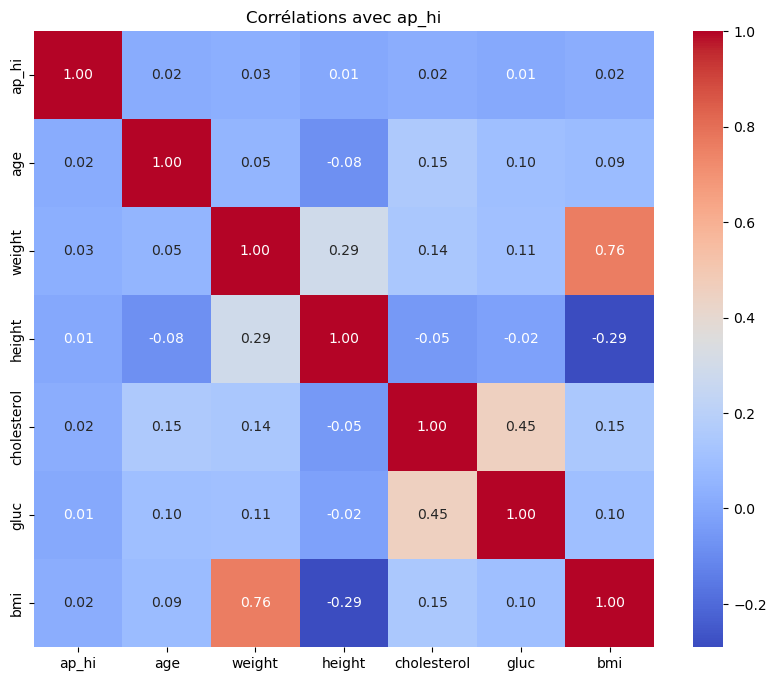

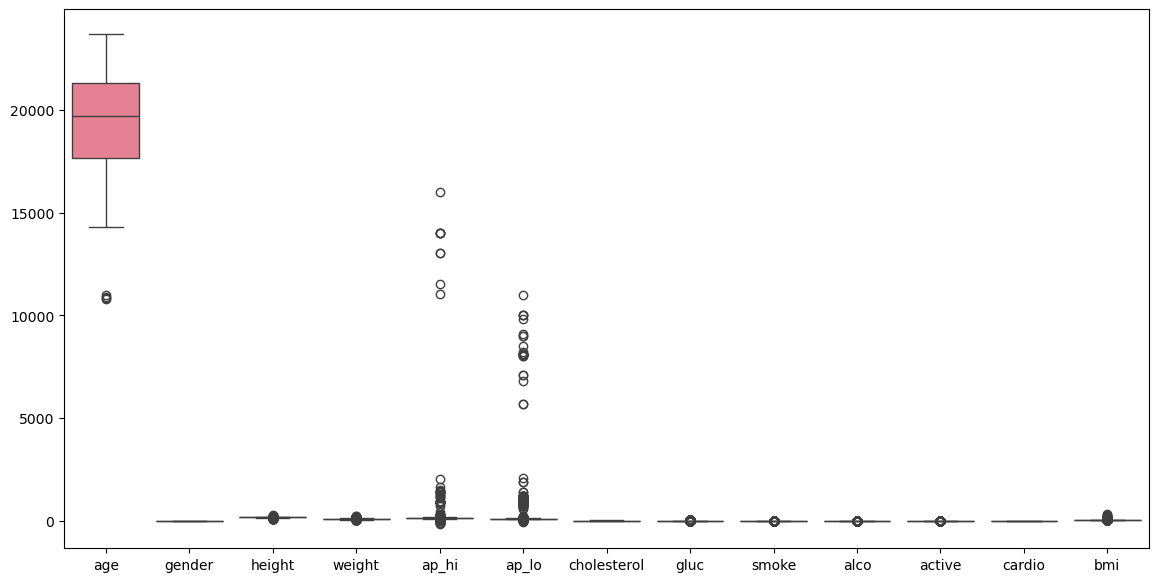

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Crée la colonne BMI ou IMC (en français)
df['bmi'] = df['weight'] / (df['height']/100)**2

# Définis X en gardant bien 'bmi'
X = df.drop(columns=['ap_hi'])  # 'bmi' est maintenant dans X
y = df['ap_hi']

# Sélectionner uniquement les variables pertinentes pour la matrice
corr_vars = ['ap_hi', 'age', 'weight', 'height', 'cholesterol', 'gluc', 'bmi',]
correlation = df[corr_vars].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Corrélations avec ap_hi')
plt.show()

# Affichage du boxplot seaborn pour les visualiser les outliers
plt.figure(figsize = (14,7))
sns.boxplot(data=df.drop(columns=['id']))
plt.show()

Le prétraitement initiale a mis en évidence plusieurs caractéristiques importantes :
- Aucune valeur manquante n'a été détectée dans le dataset, facilitant les étapes de prétraitement.
- Présence de valeurs aberrantes dans plusieurs variables, notamment les pressions artérielles (`ap_hi`, `ap_lo`) et les variables anthropométriques (`age`).
- Corrélations significatives entre certaines variables (représenté par la couleur beige), en particulier entre l'indice de masse corporelle (`bmi`) et le poids (`weight`) (0.76), et entre le cholestérol (`cholesterol`) et le glucose (`gluc`) (0.45).

### b. Nettoyage des données
Le nettoyage des données s'est avéré être très important et indispensable pour garantir la performance des modèles. Nous avons procédé par étapes progressives :
- Identification des outliers par méthode de l'IQR (Interquartile Range) pour l'âge après avoir visualiser le boxplot.
- Filtrage des valeurs physiologiquement improbables pour les pressions artérielles.

### Identification des outliers

In [6]:
# Identification des outliers pour l'âge
column = 'age'  # C'est la colonne où j'ai vu l'outlier

# Calculer l'IQR, les limites inférieures et supérieures
Q1 = df[column].quantile(0.25)
Q3 = df[column].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Trouver les lignes aberrantes
outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# On ne supprime pas, on ne garde que les données non aberrantes
df = df[(df['age'] >= lower_bound) & (df['age'] <= upper_bound)]

print(outliers)

          id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  \
6219    8850  10878       1     175    59.0    120     80            1     1   
22343  31922  10798       2     175    92.0    100     60            1     1   
30666  43842  10859       1     159    59.0    120     80            1     1   
55905  79749  10964       1     160    59.0    110     70            1     1   

       smoke  alco  active  cardio        bmi  
6219       0     0       1       0  19.265306  
22343      0     0       1       0  30.040816  
30666      0     0       1       0  23.337684  
55905      0     0       1       0  23.046875  


### Suppression des outliers

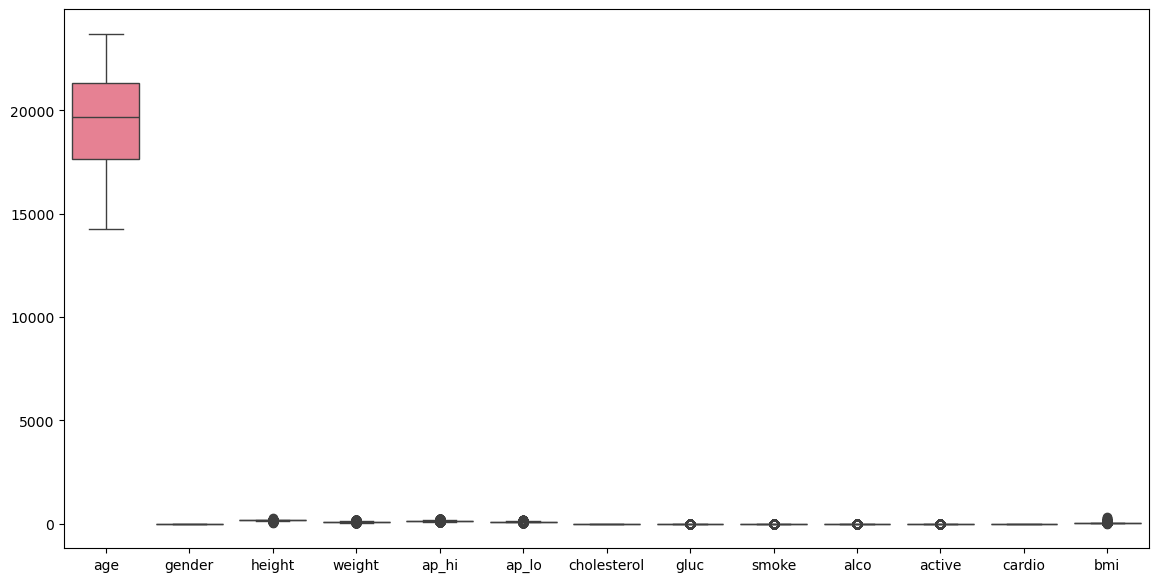

In [7]:
# Suppresion des outliers les pressions artérielles
df_clean1 = df[(df['ap_hi'] > 70) & (df['ap_hi'] < 250) & (df['ap_lo'] > 40) & (df['ap_lo'] < 180)]
df_clean_final = df_clean1.copy()  # Pour éviter les warnings

# Chargement du dataset
plt.figure(figsize = (14,7))
sns.boxplot(data=df_clean_final.drop(columns=['id']))
plt.show()

Comme vous le voyez sur le boxplot affiché ci-dessus, on a pu avec cette logique :
- Supprimer les valeurs aberrantes pour l'âge en ne gardant seulement les valeurs considérées non aberrantes.
- Supprimer les valeurs aberrantes pour les pressions artérielles systoliques (`ap_hi`) et les pressions artérielles diastoliques (`ap_lo`), en conservant uniquement les valeurs :
    - Entre 70 et 250 mm Hg pour pressions artérielles systoliques (`ap_hi`),
    - Entre 40 et 180 mm Hg pour les pressions artérielles diastoliques (`ap_lo`).

Cette approche fondée sur les plages cliniquement plausibles est plus pertinente qu'une détection purement statistique des outliers pour les paramètres médicaux.

## 3. Préparation des données
Nous allons sélectionner les variables numériques pertinentes afin de les standardiser, ce qui permet d’homogénéiser leur échelle pour l’entraînement des modèles.
Nous séparons ensuite le jeu de données en ensembles d’entraînement et de test, puis nous définissons un préprocesseur (ColumnTransformer) qui appliquera la standardisation uniquement sur ces variables numériques.
Cependant avant de faire la sélection, nous allons d'abord effectuer une régression linéaire entre chaque variable et la cible pour faciliter le choix des features.

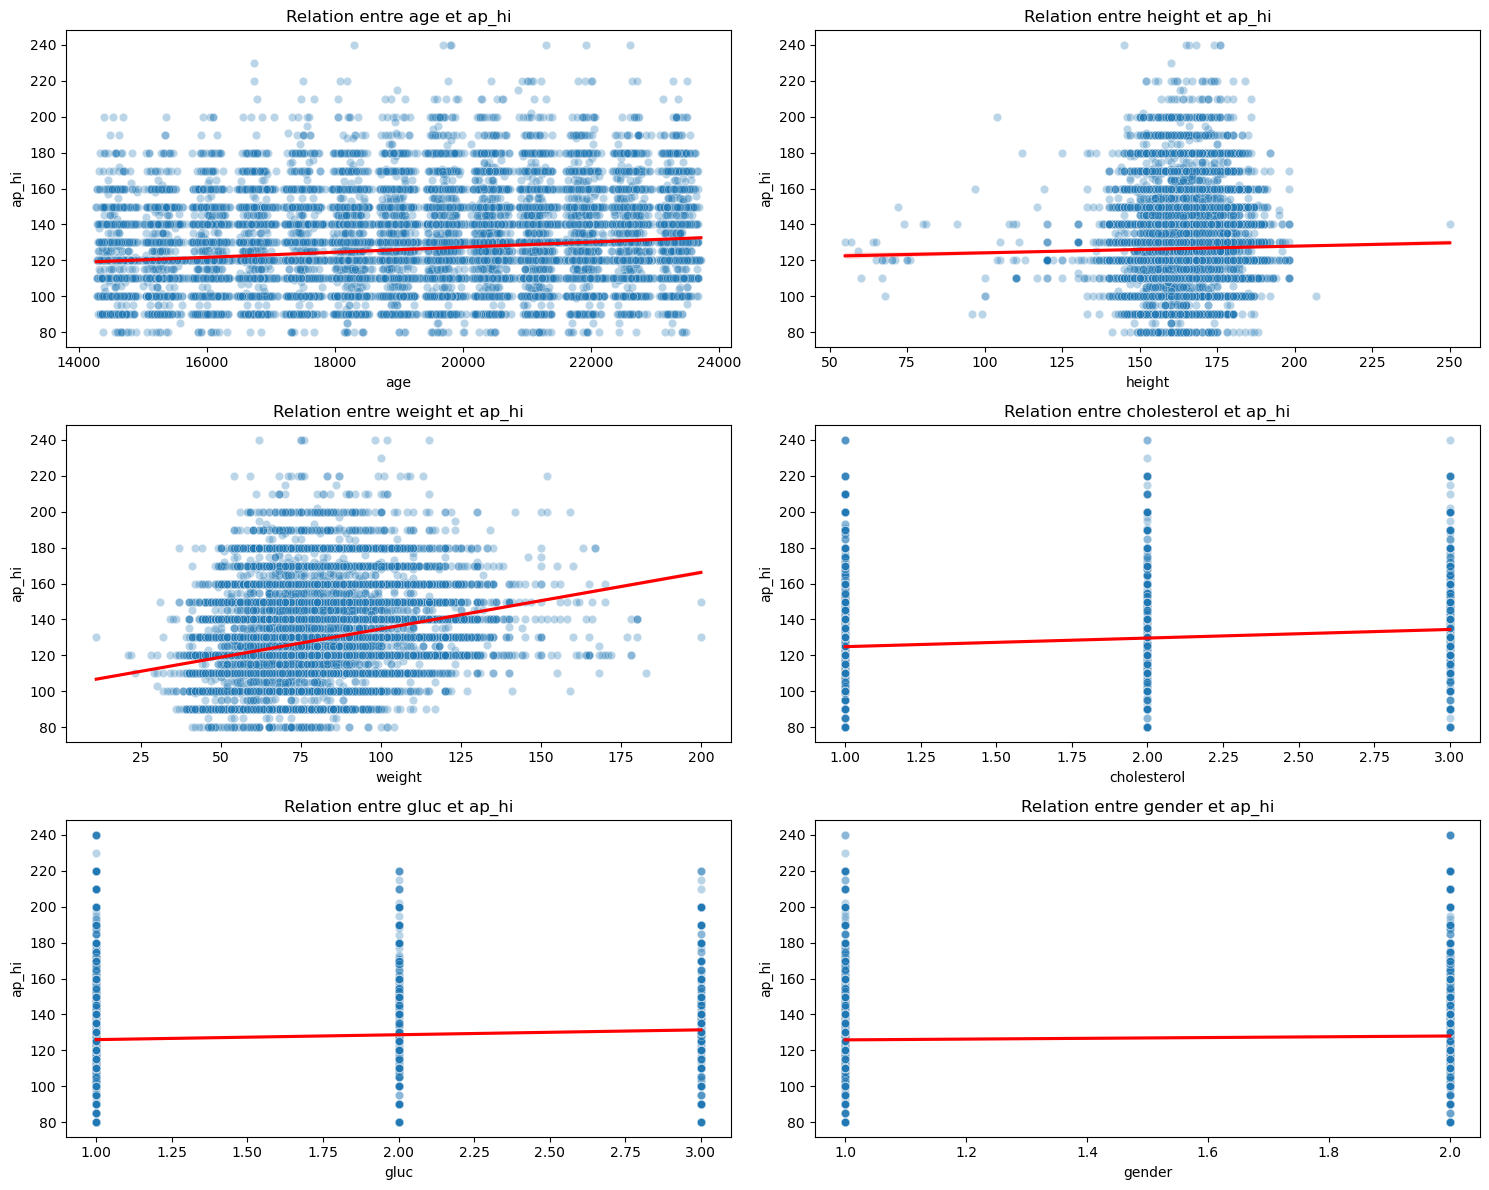

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Variables numériques à tester
variables = ['age', 'height', 'weight', 'cholesterol', 'gluc', 'gender']

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for i, var in enumerate(variables):
    sns.scatterplot(data=df_clean_final, x=var, y='ap_hi', alpha=0.3, ax=axes[i])
    axes[i].set_title(f'Relation entre {var} et ap_hi')
    
    sns.regplot(data=df_clean_final, x=var, y='ap_hi', 
                scatter=False, ax=axes[i], color='red')

plt.tight_layout()
plt.show()

Après avoir testé la régression linéaire entre chaque variable et la pression artérielle systolique, on remarque une absence forte de relation entre les autres variables et la variable à prédire. Celà nous amène à conlure que les variables contenues dans notre dataset ne nous permettront pas de prédire la pression artérielle systolique malheureusement. De ce fait, on ne peut pas avoir dans notre cas des performances acceptables.

En tenant compte des régressions linéaires effectuées entre les autres variables et la variable à prédire (`ap_hi`), nous allons donc sélectionner les variables numériques jugées pertinentes (`age`, `weight`, `bmi`, `cholesterol` et `gluc`) afin de les standardiser, ce qui va nous permettre d’homogénéiser leur échelle pour l’entraînement des modèles. Nous allons ensuite séparer le jeu de données en ensembles d’entraînement et de test, puis définir un préprocesseur (ColumnTransformer) qui appliquera la standardisation uniquement sur ces variables numériques.

In [9]:
# Liste des features numériques à standardiser
numerical_features = ['age', 'weight', 'bmi', 'cholesterol', 'gluc']

# Split train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Préprocesseur
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
])

## 4. Modèles de régression
Nous allons construire ici un pipeline scikit-learn combinant le prétraitement des variables numériques (standardisation) et chaque modèle de régression : Random Forest, Gradient Boosting, Linear Regression et SGD Regressor.
Nous utilisons ensuite GridSearchCV pour rechercher automatiquement les meilleurs hyperparamètres du modèle (nombre d’arbres, profondeur maximale), avec une validation croisée à maximum 5 folds et la métrique R² comme critère d’optimisation.
Cette approche garantit une optimisation rigoureuse et reproductible du modèle sur nos données.

NB : Nous allons limiter le nombre de paramètres testés pour chaque modèle afin de garantir une exécution rapide et raisonnable sur notre machine, compte tenu de la limite de temps.

### a. Random Forest Regressor

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
])

param_grid_rf = {

    'regressor__n_estimators': [100],
    'regressor__max_depth': [10, None]
}

grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=3, scoring='r2', n_jobs=-1)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'weight',
                                                                          'bmi',
                                                                          'cholesterol',
                                                                          'gluc'])])),
                                       ('regressor',
                                        RandomForestRegressor(n_jobs=-1,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [10, None],
                         'regressor__n_estimators': [100]},
             scoring='r2')

### b. Gradient Boosting Regressor

In [11]:
from sklearn.ensemble import GradientBoostingRegressor

pipeline_gb = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

param_grid_gb = {
    'regressor__n_estimators': [200],
    'regressor__learning_rate': [0.1, 0.05],
    'regressor__max_depth': [5]
}

grid_gb = GridSearchCV(pipeline_gb, param_grid_gb, cv=3, scoring='r2', n_jobs=-1)
grid_gb.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'weight',
                                                                          'bmi',
                                                                          'cholesterol',
                                                                          'gluc'])])),
                                       ('regressor',
                                        GradientBoostingRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__learning_rate': [0.1, 0.05],
                         'regressor__max_depth': [5],
                         'regressor__n_estimators': [200]},
             scoring='r2')

### c. Linear Regression

In [12]:
from sklearn.linear_model import LinearRegression

pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'weight', 'bmi',
                                                   'cholesterol', 'gluc'])])),
                ('regressor', LinearRegression())])

### d. SGD Regressor

In [13]:
from sklearn.linear_model import SGDRegressor

pipeline_sgd = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SGDRegressor(max_iter=1000, tol=1e-3, random_state=42))
])

pipeline_sgd.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'weight', 'bmi',
                                                   'cholesterol', 'gluc'])])),
                ('regressor', SGDRegressor(random_state=42))])

## 5. Evaluation des modèles
Nous allons tout de même évaluer nos modèles de régression dans cette partie.


=== Random Forest ===
R²: -0.10354926598548797
MSE: 33737.82540312458
RMSE: 183.6785926642639
MAE: 17.917680788265308


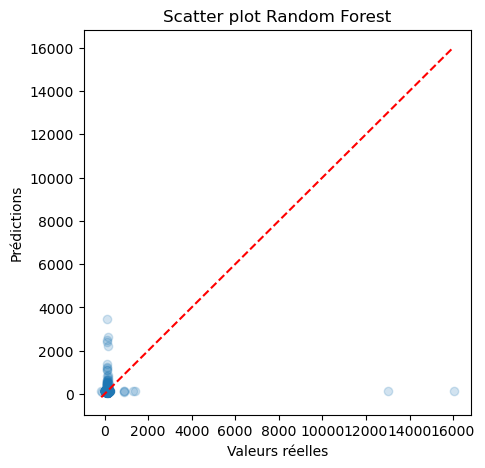

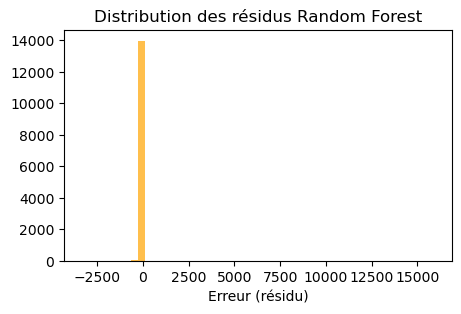


=== Gradient Boosting ===
R²: -0.1829177771316144
MSE: 36164.28795816303
RMSE: 190.16910358458082
MAE: 17.032929563035466


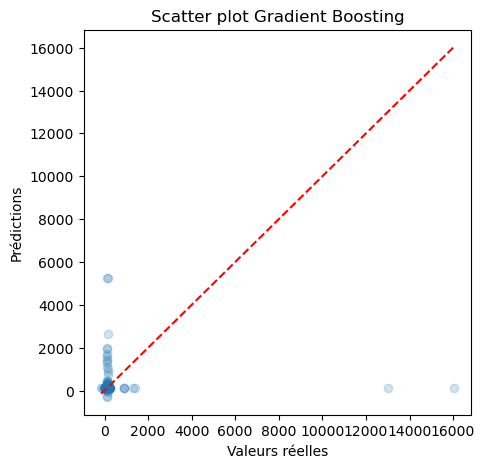

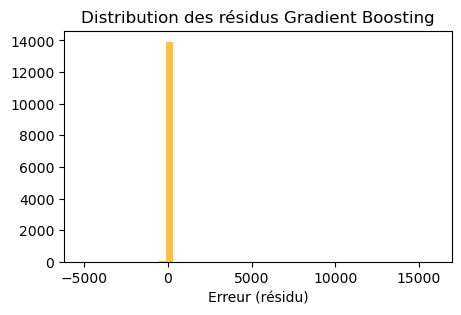


=== Linear Regression ===
R²: 0.0009506007982974518
MSE: 30543.044373523047
RMSE: 174.76568419893835
MAE: 15.017121064147442


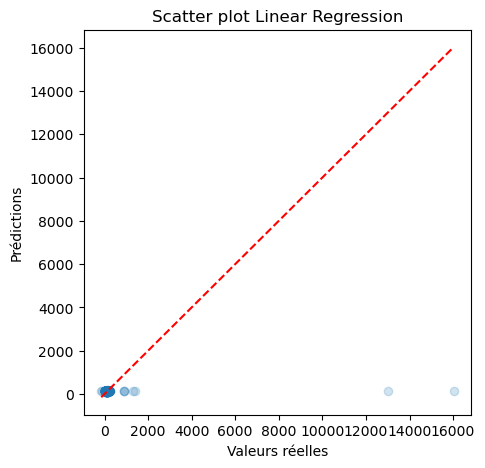

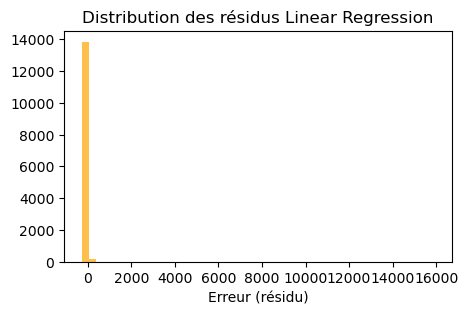


=== SGD Regressor ===
R²: 0.0008157514276443401
MSE: 30547.167002809343
RMSE: 174.77747853430472
MAE: 15.499494024214252


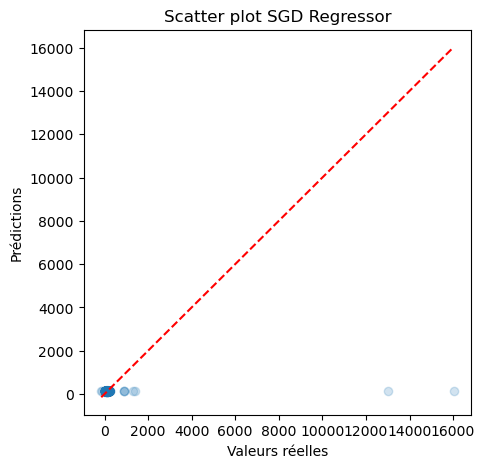

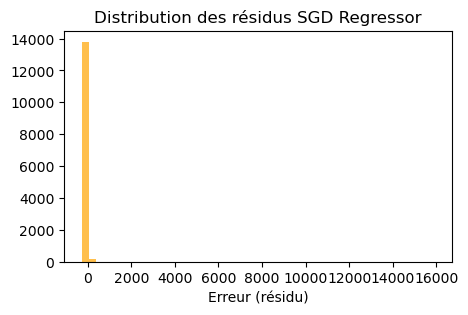

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

models = {
    'Random Forest': grid_rf.best_estimator_,
    'Gradient Boosting': grid_gb.best_estimator_,
    'Linear Regression': pipeline_lr,
    'SGD Regressor': pipeline_sgd
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\n=== {name} ===")
    print("R²:", r2_score(y_test, y_pred))
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("MAE:", mean_absolute_error(y_test, y_pred))
    # Scatter plot
    # C'est pas forcément utile
    plt.figure(figsize=(5,5))
    plt.scatter(y_test, y_pred, alpha=0.2)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Valeurs réelles")
    plt.ylabel("Prédictions")
    plt.title(f"Scatter plot {name}")
    plt.show()
    # Distribution des résidus
    plt.figure(figsize=(5,3))
    plt.hist(y_test - y_pred, bins=50, color='orange', alpha=0.7)
    plt.title(f"Distribution des résidus {name}")
    plt.xlabel("Erreur (résidu)")
    plt.show()

### Interprétation
Nos résultats précédents peuvent être interpréter comme suit :
- R² faible (-0.18 - 0) : les modèles n’expliquent pas du tout la variance de la pression systolique.
- EQM (MSE) élevé : l’erreur quadratique moyenne est importante par rapport à l’échelle de la variable.
- Erreur absolue moyenne (MAE) > 11 mm Hg : ce qui est important en contexte médical.
### Discussion et limites
Pourquoi on a des performances faible ? Prédire la pression artérielle à partir de simples données démographiques et cliniques posent un problème dans notre cas. Les modèles de Machine Learning sont puissants, mais ils ne peuvent pas inventer les informations absentes du dataset (volume d'éjection systolique (VES), rigidité artérielle, marqueurs biologiques, etc...). Aussi, les ressources informatiques sont limitées : entraîner un modèle complexe sur 70 000 lignes prend beaucoup de temps, surtout avec la validation croisée. C’est pourquoi nous avons parfois utilisé un sous-échantillon pour le tuning, avant de réentraîner sur l’ensemble. Mais c'est plus le fait que ces variables n'ont aucune relation forte avec la pression artérielle systolique comme on l'avait montré un peu plus haut. Donc on ne peut pas espérer de bonnes performances vu que c'est impossible de prédire la pression artérielle systolique avec ces quelques données démographiques et cliniques, il nous manque cruellement d'autres facteurs plus adaptés.

# Conclusion
Pour conclure cette dernière partie de régression, les modèles testés (Random Forest, Gradient Boosting, Linear Regression, SGD) n’ont pas permis de prédire précisément la pression artérielle systolique à partir des variables disponibles. Personnellement, nous pensons qu'on ne peut pas mieux faire, et ceci est dû à l'absence cruciale d'indicateurs adaptés pour prédire la pression artérielle. Mais aussi, du fait que nos modèles ont du mal à entrainer, il nous faudra d'autres modèles beaucoup plus complexes que ceux là pour la prédiction de notre régression à cause du dataset qui est un peu trop volumineux. Des pistes d’amélioration incluraient du coup l’ajout de variables plus informatives comme les antécédents médicaux.